In [2]:
import micrograd as mg
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

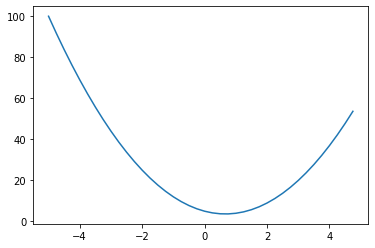

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.001
x = 2/3
(f(x+h) - f(x))/h

0.0029999999995311555

In [8]:
# more complex use case
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [9]:
h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 3.997
slope: -3.0000000000001137


In [10]:
h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 4.002
slope: 1.9999999999997797


In [11]:
h = 0.001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 4.0009999999999994
slope: 0.9999999999994458


In [12]:
class Value: 
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # giving a nicer looking expression
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
      
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L= d*f; L.label='L'
L


Value(data=-8.0)

In [13]:
a = Value(2.0)
b = Value(4.0)
b/a

Value(data=2.0)

In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

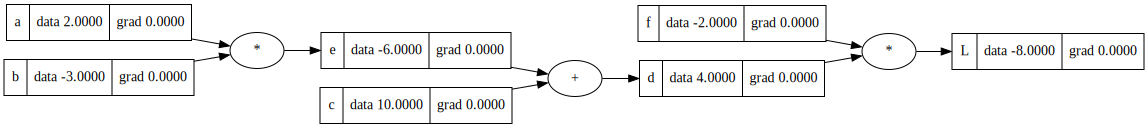

In [15]:
draw_dot(L)

In [16]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-36.0


In [17]:
L.grad=1.0
f.grad = 4.0
d.grad =-2.0
c.grad=-2.0
e.grad=-2.0
a.grad=6.0
b.grad=-4.0

In [18]:
#Verifying grads
def lol():
    
    h= 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L= d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')
    e = (a*b); e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L= d*f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()


-3.9999999999995595


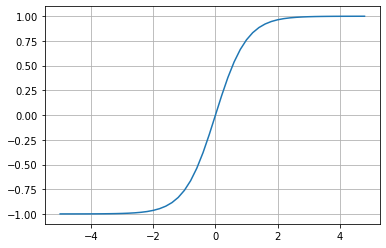

In [19]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [20]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

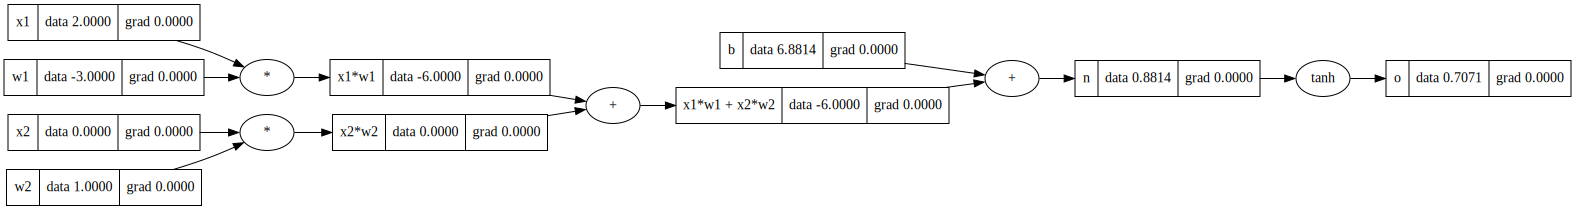

In [21]:
draw_dot(o)

In [22]:
o.backward()

In [23]:
o.grad =1.0
o._backward()

In [24]:
n._backward()

In [25]:
x1w1x2w2._backward()

In [26]:
x1w1._backward()

In [27]:
x2w2._backward()

In [28]:
#Back propagation manually
#o.grad = 1.0
#n.grad = 0.5
#x1w1x2w2.grad = 0.5
#b.grad = 0.5
#x1w1.grad = 0.5
#x2w2.grad = 0.5
#x1.grad = w1.data * x1w1.grad
#x2.grad = w2.data * x2w2.grad
#w1.grad = x1.data * x1w1.grad
#w2.grad = x2.data * x2w2.grad

In [29]:
# o = tanh(n)
# do/dn = 1- tanh(n)**2
# do/dn = 1 - o**2
1 - o.data**2
# n.grad = 0.5

0.4999999999999999

In [30]:
# Topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

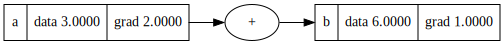

In [31]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

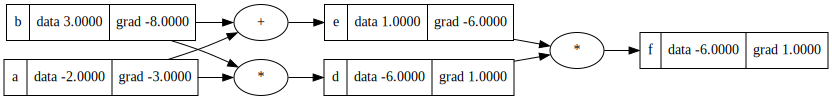

In [32]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

# so we see a bug if a variable is used more than once. Must fix by added += in _backwards functions in add and mul

In [33]:
#Repeat of box above for start of second lecture

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

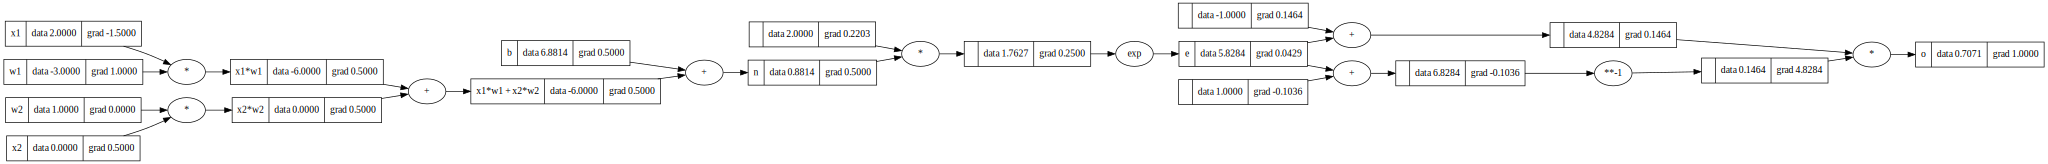

In [50]:
draw_dot(o)

In [49]:
#Repeat of box above for start of second lecture

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()

In [36]:
import torch


In [37]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2:', x2.grad.item())
print('w2:', w2.grad.item())
print('x1:', x1.grad.item())
print('w1:', w1.grad.item())

0.7071066904050358
---
x2: 0.5000001283844369
w2: 0.0
x1: -1.5000003851533106
w1: 1.0000002567688737


In [38]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [39]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [40]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [41]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9790482331250981)

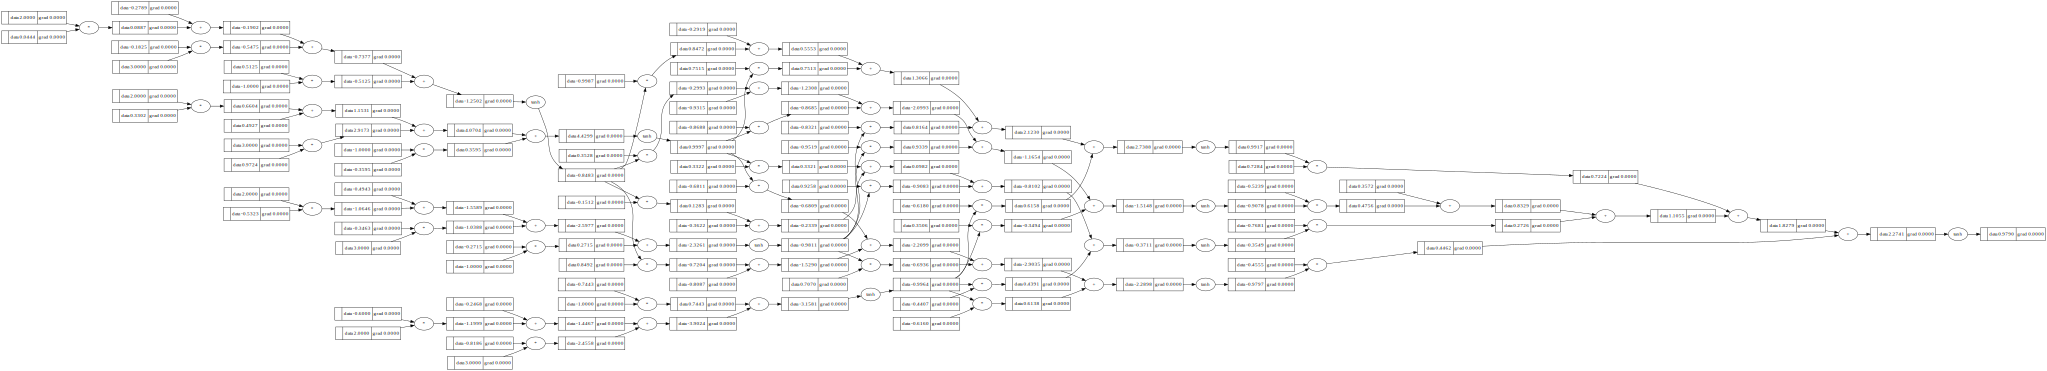

In [42]:
draw_dot(n(x))

In [43]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Binary classifier neural net

In [44]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9790482331250981),
 Value(data=0.9637502269701569),
 Value(data=0.9756153507883412),
 Value(data=0.9780432899761046)]

In [45]:
for k in range(20):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
  
    print(k, loss.data)

0 7.760292041846137
1 7.548897280773093
2 6.08974153861023
3 2.5352834627041343
4 0.9835971289897092
5 0.4355007028186689
6 0.09486323405049384
7 0.06289532413366367
8 0.0491834064056
9 0.040802667248200565
10 0.034978407538916054
11 0.030642148021378206
12 0.027269113778737523
13 0.024563047195871563
14 0.022340955826849567
15 0.02048248383986484
16 0.018904708209078157
17 0.017548405532607253
18 0.01637004258093542
19 0.015336851219562974


In [46]:
ypred

[Value(data=0.9326433868093591),
 Value(data=-0.9703751625819446),
 Value(data=-0.9265288411852661),
 Value(data=0.9327371149189742)]

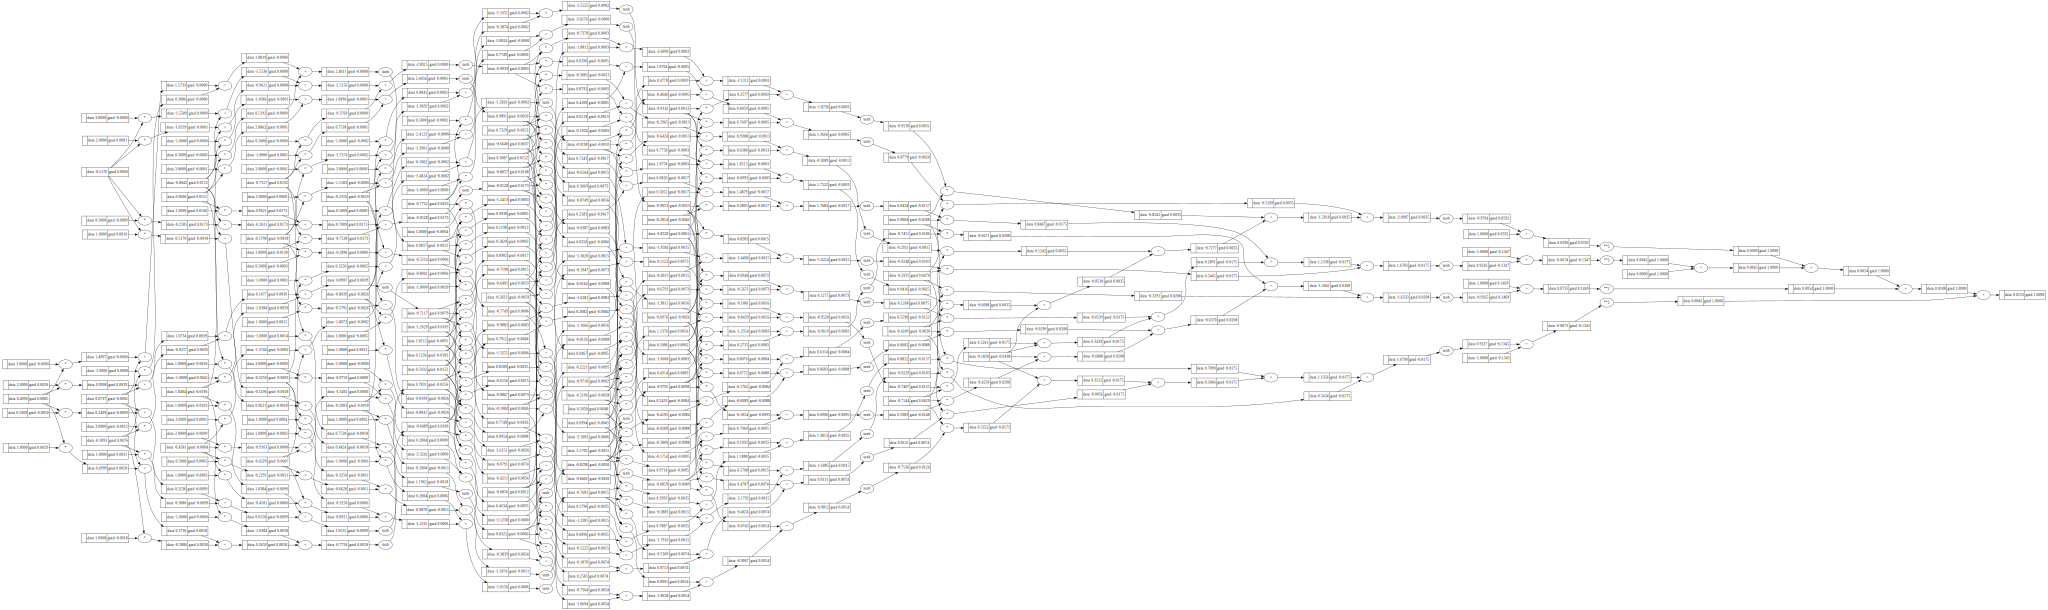

In [47]:
draw_dot(loss)

In [48]:
n.parameters()

[Value(data=0.4990292837057944),
 Value(data=-0.3093435190966704),
 Value(data=1.0403843120669212),
 Value(data=0.07370528317811721),
 Value(data=-0.5176263700032457),
 Value(data=0.9605606627444745),
 Value(data=-0.7556815758540986),
 Value(data=-0.004196524523765716),
 Value(data=-0.4580914185302356),
 Value(data=-0.3249585458263272),
 Value(data=-0.20025223788615695),
 Value(data=-0.43289036454958507),
 Value(data=-0.5789532910201464),
 Value(data=-0.8038793298649108),
 Value(data=-0.7751825470054011),
 Value(data=-0.2316240314672017),
 Value(data=0.5931912182703291),
 Value(data=-0.885668963166736),
 Value(data=-1.1704605037937754),
 Value(data=0.10860323905711618),
 Value(data=-0.6855722865776366),
 Value(data=0.1236437265944919),
 Value(data=0.30871532635352067),
 Value(data=0.6994039806748815),
 Value(data=-0.6975909017068981),
 Value(data=-0.10842713391470275),
 Value(data=-1.2629303759008825),
 Value(data=0.732850662831804),
 Value(data=-0.5196094097266055),
 Value(data=-0.281